### 导入模拟数据

使用模拟数据，测试模型

In [1]:
import os
import numpy as np
import tensorflow as tf

os.chdir("/home/num_24/桌面/mywork/github/TFDeepSurv")
os.getcwd()

np.random.seed(10)

from dataset import SimulatedData
import LDeepSurv as LDS

data_config = SimulatedData(100, num_features = 10)
data = data_config.generate_data(2000)
sort_idx = np.argsort(data['t'])[::-1]
data['x'] = data['x'] [sort_idx]
data['e'] = data['e'] [sort_idx]
data['t'] = data['t'] [sort_idx]

features:  10
-------------------------------------------------
training steps 1:
loss = 11526.

CI = 0.496154.

-------------------------------------------------
training steps 101:
loss = 11521.4.

CI = 0.523017.

-------------------------------------------------
training steps 201:
loss = 11514.4.

CI = 0.528076.

-------------------------------------------------
training steps 301:
loss = 11342.2.

CI = 0.658626.

-------------------------------------------------
training steps 401:
loss = 11001.9.

CI = 0.731536.

-------------------------------------------------
training steps 501:
loss = 10877.5.

CI = 0.74527.

-------------------------------------------------
training steps 601:
loss = 10831.1.

CI = 0.753069.

-------------------------------------------------
training steps 701:
loss = 10822.1.

CI = 0.754373.

-------------------------------------------------
training steps 801:
loss = 10811.1.

CI = 0.755818.

-------------------------------------------------
training steps

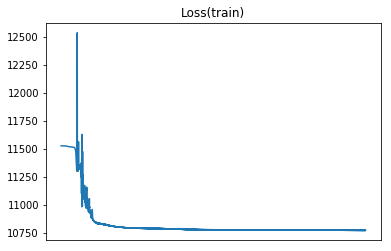

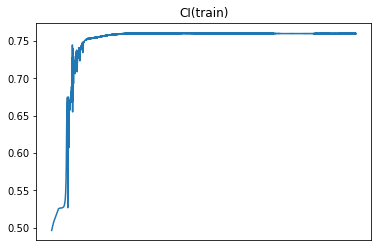

In [2]:
n_features = data['x'].shape[1]
print("features: ", n_features)
model = LDS.LDeepSurv(n_features, [6,3], 1, 
                      learning_rate=0.001, learning_rate_decay = 0.95, 
                      activation='tanh', 
                      L1_reg=0.01, 
                      optimizer='adam')

model.train(data['x'], {'e': data['e'], 't': data['t']}, 
            num_epoch=5000, iteration=100,
            plot_train_loss=True, plot_train_CI=True)

In [3]:
model.eval(data['x'], {'e': data['e'], 't': data['t']})

CI on test set = 0.759408.


0.75940834779290622

In [4]:
print(model.sess)

In [5]:
model.sess.close()

In [6]:
model.eval(data['x'], {'e': data['e'], 't': data['t']})

RuntimeError: Attempted to use a closed Session.

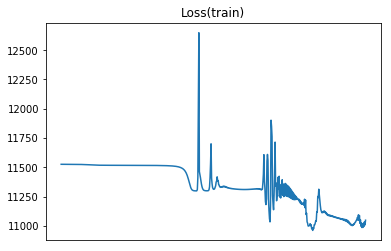

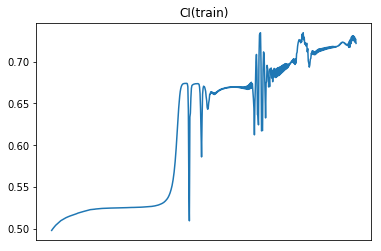

In [6]:
model0 = LDS.LDeepSurv(n_features, [6,3], 1, learning_rate=0.001, activation='tanh', L2_reg=0.01, optimizer='adam')

model0.train(data['x'], {'e': data['e'], 't': data['t']}, num_epoch=600, plot_train_loss=True, plot_train_CI=True)

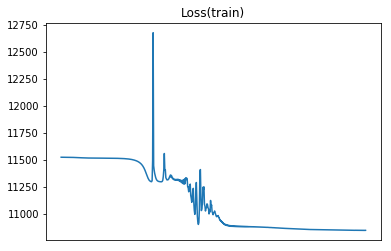

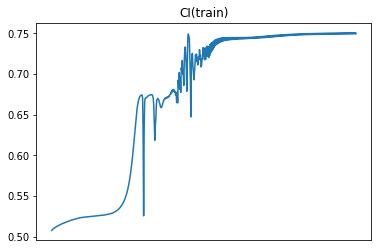

In [4]:
model2 = LDS.LDeepSurv(n_features, [6,3], 1, learning_rate=0.001, activation='tanh', L2_reg=0.01, optimizer='adam')

model2.train(data['x'], {'e': data['e'], 't': data['t']}, num_epoch=600, plot_train_loss=True, plot_train_CI=True)

features:  10


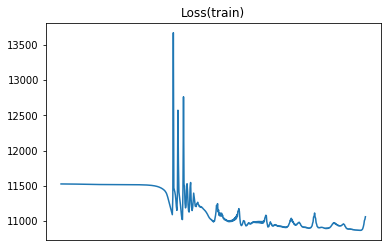

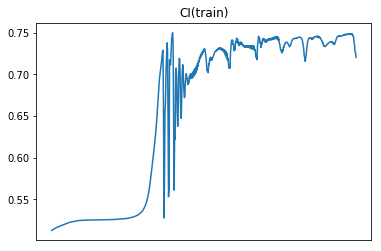

In [3]:
n_features = data['x'].shape[1]
print("features: ", n_features)
model = LDS.LDeepSurv(n_features, [6,3], 1, learning_rate=0.001, activation='tanh', L2_reg=0.01)

model.train(data['x'], {'e': data['e'], 't': data['t']}, num_epoch=600, plot_train_loss=True, plot_train_CI=True)

In [3]:
import tensorflow as tf

print(tf.global_variables())

[<tf.Variable 'layer1/weights:0' shape=(10, 6) dtype=float32_ref>, <tf.Variable 'layer1/biases:0' shape=(6,) dtype=float32_ref>, <tf.Variable 'layer2/weights:0' shape=(6, 3) dtype=float32_ref>, <tf.Variable 'layer2/biases:0' shape=(3,) dtype=float32_ref>, <tf.Variable 'layer_last/weights:0' shape=(3, 1) dtype=float32_ref>, <tf.Variable 'layer_last/biases:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'training_step/global_step:0' shape=() dtype=int32_ref>]


In [4]:
with tf.Session() as sess:
    c = tf.get_collection('losses')
    x = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    y = tf.get_collection(tf.GraphKeys.WEIGHTS)
    print(c, x, y)

[] [<tf.Tensor 'layer1/weights/Regularizer/l1_l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'layer2/weights/Regularizer/l1_l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'layer_last/weights/Regularizer/l1_l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'get_regularization_penalty:0' shape=() dtype=float32>] []


In [5]:
print(tf.trainable_variables())

[<tf.Variable 'layer1/weights:0' shape=(10, 6) dtype=float32_ref>, <tf.Variable 'layer1/biases:0' shape=(6,) dtype=float32_ref>, <tf.Variable 'layer2/weights:0' shape=(6, 3) dtype=float32_ref>, <tf.Variable 'layer2/biases:0' shape=(3,) dtype=float32_ref>, <tf.Variable 'layer_last/weights:0' shape=(3, 1) dtype=float32_ref>, <tf.Variable 'layer_last/biases:0' shape=(1,) dtype=float32_ref>]
